In [1]:
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *
from PIL import Image
import scipy.signal as signal
import warnings
warnings.simplefilter('ignore')

In [2]:
def plot_spike_counts(name, layer_shape, fig_num):
    x_L = layer_shape[0]
    y_L = layer_shape[1]
    spike_copy = np.copy(spike_monitors[name].count)
    spike_matrix = np.zeros(layer_shape)
    for i in range(y_L):
        for j in range(x_L):
            spike_matrix[i,j] = spike_copy[i*x_L + j]

    unique_list = unique(spike_matrix)
    max_val = max(unique_list)
    min_val = min(unique_list)

    fig = figure(fig_num, figsize = (8, 8))
    im2 = imshow(spike_matrix, interpolation = "nearest", vmin = min_val, vmax = max_val , cmap = cmap.get_cmap('hot_r'))
    colorbar(im2)
    title('number of spikes - ' + name + ' layer')

In [3]:
def get_matrix_from_file(fileName, shape):
    readout = np.load(fileName)
    print(readout.shape, fileName)
    value_arr = np.zeros(shape)
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr

In [4]:
def gaussian2D(x, y, sigma):
    return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/((sigma**2)))*(x**2 + y**2))
#     return (1.0/(1*math.pi*(sigma**2)))*math.exp(-(1.0/(2*math.pi*(sigma**2)))*(x**2 + y**2))

def mexicanHat(x,y,sigma1,sigma2): 
    return gaussian2D(x,y,sigma1) - gaussian2D(x,y,sigma2)

def receptiveFieldMatrix(func):
    h = 11
    g = np.zeros((h,h))
    for xi in range(0,h):
        for yi in range(0,h):
            x = xi-int(h/2)
            y = yi-int(h/2)
            g[xi, yi] = func(x,y);
    return g

In [5]:
def plot_image(image, fig_num):
    unique_list = unique(image)
    max_val = max(unique_list)
    min_val = min(unique_list)
    fig = figure(fig_num, figsize = (5, 5))
    img = imshow(image, interpolation = "nearest", vmin = min_val, vmax = max_val , cmap = cmap.get_cmap('hot_r'))
    colorbar(img)

In [6]:
def tune_stimuli(data):
    data = (data - data.min()) / (data.max() - data.min())
    q95 = np.percentile(data, 95)
    data = np.where((data > q95), q95, data)
    data = np.exp(data*5)
    data = (data - data.min()) / (data.max() - data.min())
    data *= 20
    return data

# CODE

In [7]:
stimuli_file = './pic_100.tif'
weight_path = './initial_weights/'
save_path = './saved_weights/'

fig_num = 1

length = 100
field_size = 5                     # 2/3/4/5/6

w_s = field_size*1                # simple cell width
l_s = field_size*2                # simple_cell_length

n_LGN = length*length
n_L4 = (length//(w_s*2))*(length//l_s)

num_epochs = 8

single_example_time = 0.35 * second
resting_time = 0.15 * second

delay = {}
delay = (0*ms, 10*ms)              # min and max delay
minDelay = delay[0]
maxDelay = delay[1]
deltaDelay = maxDelay - minDelay

# neural model parameters
v_rest_e = -65. * mV
v_rest_i = -60. * mV
v_reset_e = -65. * mV
v_reset_i = -45. * mV
v_thresh_e = -52. * mV
v_thresh_i = -40. * mV
refrac_e = 5. * ms
refrac_i = 2. * ms
tc_theta = 1e7 * ms
theta_plus_e = 0.05 * mV
offset = 20.0 * mV

# STDP parameters
tc_pre = 20*ms
tc_post_1 = 20*ms
tc_post_2 = 40*ms
nu_pre =  0.0001
nu_post = 0.01
wmax = 100.0

input_intensity = 1.
start_input_intensity = input_intensity

update_interval = 2

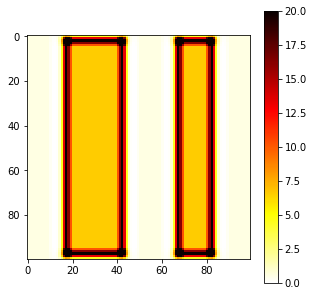

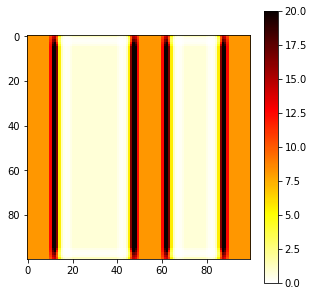

In [8]:
img = Image.open(stimuli_file)
img.load()
img_arr = np.asarray(img, dtype="int32")
stimuli = np.absolute(img_arr)/255
img.close()

stimuli_on = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,3,4)), mode='same')
stimuli_on = tune_stimuli(stimuli_on)
plot_image(stimuli_on, fig_num)
fig_num += 1

stimuli_off = signal.convolve(stimuli, receptiveFieldMatrix(lambda x,y:mexicanHat(x,y,4,3)), mode='same')
stimuli_off = tune_stimuli(stimuli_off)
plot_image(stimuli_off, fig_num)
fig_num += 1

In [9]:
scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
v_reset_i_str = 'v = v_reset_i'

v_thresh_e_str = '(v > (theta - offset + v_thresh_e)) and (timer > refrac_e)'
v_thresh_i_str = 'v > v_thresh_i'

neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + g_e*(-v) + g_i*(-100.*mV - v) ) / (100*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
        dtheta/dt = -theta/(1e7*ms)                                : volt
        dtimer/dt = 0.1                                            : second
'''

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) +  g_e*(-v) + g_i*(-85.*mV - v)) / (10*ms)  : volt (unless refractory)
        dg_e/dt = -g_e/(1.0*ms)                                    : 1
        dg_i/dt = -g_i/(2.0*ms)                                    : 1
'''


neuron_groups = {}

# ON first - OFF second
neuron_groups['L4_i_NF_v']  = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
neuron_groups['L4_NF_v']    = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
neuron_groups['L4_i_NF_v'].v  = v_rest_i - 40.*mV
neuron_groups['L4_NF_v'].v    = v_rest_e - 40.*mV 
neuron_groups['L4_NF_v'].theta = np.ones((n_L4)) * 20.0*mV

# OFF first - ON second
neuron_groups['L4_i_FN_v']  = NeuronGroup(n_L4, neuron_eqs_i, threshold=v_thresh_i_str, refractory=refrac_i, reset=v_reset_i_str, method='euler')
neuron_groups['L4_FN_v']    = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
neuron_groups['L4_i_FN_v'].v  = v_rest_i - 40.*mV
neuron_groups['L4_FN_v'].v    = v_rest_e - 40.*mV 
neuron_groups['L4_FN_v'].theta = np.ones((n_L4)) * 20.0*mV

neuron_groups['L4_v']    = NeuronGroup(n_L4, neuron_eqs_e, threshold=v_thresh_e_str, refractory=refrac_e, reset=scr_e, method='euler')
neuron_groups['L4_v'].v    = v_rest_e - 40.*mV 
neuron_groups['L4_v'].theta = np.ones((n_L4)) * 20.0*mV

input_groups = {}
input_groups['LGN_on']   = PoissonGroup(n_LGN, 0*Hz)
input_groups['LGN_off']  = PoissonGroup(n_LGN, 0*Hz)

In [10]:
# without STDP
model = 'w : 1'
pre_e = 'g_e_post += w'
pre_i = 'g_i_post += w'
post = ''

# with STDP
stdp_model = '''
    w                                   : 1
    dpre/dt   =   -pre/(tc_pre)         : 1 (event-driven)
    dpost1/dt  = -post1/(tc_post_1)     : 1 (event-driven)
    dpost2/dt  = -post2/(tc_post_2)     : 1 (event-driven)
'''
stdp_pre_e = 'pre = 1.; w = clip(w + nu_pre * post1, 0, wmax); g_e_post += w;'
stdp_pre_i = 'pre = 1.; w = clip(w + nu_pre * post1, 0, wmax); g_i_post += w;'
stdp_post = 'post1 = 1.; post2 = 1.; w = clip(w + nu_post * pre * post2, 0, wmax)'

In [11]:
connections = {}
#[name, shape, weight_file, source, target, equation_type]

input_neuron_conn = [
    ['LGN_on_L4_NF_v', (n_LGN, n_L4), 'LGN_L4_v_on.npy', 'LGN_on', 'L4_NF_v', 'e'],
    ['LGN_off_L4_NF_v', (n_LGN, n_L4), 'LGN_L4_v_off.npy', 'LGN_off', 'L4_NF_v', 'e'],
    ['LGN_off_L4_i_NF_v', (n_LGN, n_L4), 'LGN_L4_v_on.npy', 'LGN_off', 'L4_i_NF_v', 'e'],
    ['LGN_on_L4_i_NF_v', (n_LGN, n_L4), 'LGN_L4_v_off.npy', 'LGN_on', 'L4_i_NF_v', 'e'],
    
    ['LGN_off_L4_FN_v', (n_LGN, n_L4), 'LGN_L4_v_on.npy', 'LGN_off', 'L4_FN_v', 'e'],
    ['LGN_on_L4_FN_v', (n_LGN, n_L4), 'LGN_L4_v_off.npy', 'LGN_on', 'L4_FN_v', 'e'],
    ['LGN_on_L4_i_FN_v', (n_LGN, n_L4), 'LGN_L4_v_on.npy', 'LGN_on', 'L4_i_FN_v', 'e'],
    ['LGN_off_L4_i_FN_v', (n_LGN, n_L4), 'LGN_L4_v_off.npy', 'LGN_off', 'L4_i_FN_v', 'e']
]

neuron_neuron_conn = [
    ['L4_i_L4_NF_v', (n_L4, n_L4), 'L4_i_L4.npy', 'L4_i_NF_v', 'L4_NF_v', 'i'],
    ['L4_i_L4_FN_v', (n_L4, n_L4), 'L4_i_L4.npy', 'L4_i_FN_v', 'L4_FN_v', 'i'],
    ['L4_NF_L4_v', (n_L4, n_L4), 'L4_i_L4.npy', 'L4_NF_v', 'L4_v', 'e'],
    ['L4_FN_L4_v', (n_L4, n_L4), 'L4_i_L4.npy', 'L4_FN_v', 'L4_v', 'e']
]

for conn in input_neuron_conn:
    name = conn[0]
    shape = conn[1]
    weight_file = conn[2]
    source = conn[3]
    target = conn[4]
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(input_groups[source], neuron_groups[target], model=model, on_pre=pre_e, on_post=post)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]
    connections[name].delay = 'minDelay + rand() * deltaDelay'
    
for conn in neuron_neuron_conn:
    name = conn[0]
    shape = conn[1]
    weight_file = conn[2]
    source = conn[3]
    target = conn[4]
    equation = conn[5]
    if (equation == 'e'):
        pre = pre_e
    elif (equation == 'i'):
        pre = pre_i
    
    weightMatrix = get_matrix_from_file(weight_path + weight_file, shape)
    connections[name]= Synapses(neuron_groups[source], neuron_groups[target], model=model, on_pre=pre, on_post=post)
    connections[name].connect(True)
    connections[name].w = weightMatrix[connections[name].i, connections[name].j]

(5000, 3) ./initial_weights/LGN_L4_v_on.npy


WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 is required. Get it with "Microsoft Visual C++ Build Tools": https://visualstudio.microsoft.com/downloads/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


(5000, 3) ./initial_weights/LGN_L4_v_off.npy
(5000, 3) ./initial_weights/LGN_L4_v_on.npy
(5000, 3) ./initial_weights/LGN_L4_v_off.npy
(5000, 3) ./initial_weights/LGN_L4_v_on.npy
(5000, 3) ./initial_weights/LGN_L4_v_off.npy
(5000, 3) ./initial_weights/LGN_L4_v_on.npy
(5000, 3) ./initial_weights/LGN_L4_v_off.npy
(100, 3) ./initial_weights/L4_i_L4.npy
(100, 3) ./initial_weights/L4_i_L4.npy
(100, 3) ./initial_weights/L4_i_L4.npy
(100, 3) ./initial_weights/L4_i_L4.npy


In [12]:
# # ON first - OFF second

# # LGN on >> L4, without STDP, 3*6 to one connection
# shape = (n_LGN,n_L4)
# weightMatrix = get_matrix_from_file(weight_path + 'LGN_L4_v_on.npy', shape)

# LGN_L4_conn['on_NF_v']= Synapses(input_groups['LGN_on'], neuron_groups['L4_NF_v'], model=model, on_pre=pre_e, on_post=post)
# LGN_L4_conn['on_NF_v'].connect(True)
# LGN_L4_conn['on_NF_v'].w = weightMatrix[LGN_L4_conn['on_NF_v'].i, LGN_L4_conn['on_NF_v'].j]
# LGN_L4_conn['on_NF_v'].delay = 'minDelay + rand() * deltaDelay'


# # LGN off >> L4, without STDP, 3*6 to one connection
# shape = (n_LGN,n_L4)
# weightMatrix = get_matrix_from_file(weight_path + 'LGN_L4_v_off.npy', shape)

# LGN_L4_conn['off_NF_v']= Synapses(input_groups['LGN_off'], neuron_groups['L4_NF_v'], model=model, on_pre=pre_e, on_post=post)
# LGN_L4_conn['off_NF_v'].connect(True)
# LGN_L4_conn['off_NF_v'].w = weightMatrix[LGN_L4_conn['off_NF_v'].i, LGN_L4_conn['off_NF_v'].j]
# LGN_L4_conn['off_NF_v'].delay = 'minDelay + rand() * deltaDelay'


# # LGN on >> L4 inhibitory, without STDP, 3*6 to one connection
# shape = (n_LGN,n_L4)
# weightMatrix = get_matrix_from_file(weight_path + 'LGN_L4_v_off.npy', shape)

# LGN_L4_conn['on_i_NF_v']= Synapses(input_groups['LGN_on'], neuron_groups['L4_i_NF_v'], model=model, on_pre=pre_e, on_post=post)
# LGN_L4_conn['on_i_NF_v'].connect(True)
# LGN_L4_conn['on_i_NF_v'].w = weightMatrix[LGN_L4_conn['on_i_NF_v'].i, LGN_L4_conn['on_i_NF_v'].j]
# LGN_L4_conn['on_i_NF_v'].delay = 'minDelay + rand() * deltaDelay'


# # LGN off >> L4 inhibitory, without STDP, 3*6 to one connection
# shape = (n_LGN,n_L4)
# weightMatrix = get_matrix_from_file(weight_path + 'LGN_L4_v_on.npy', shape)

# LGN_L4_conn['off_i_NF_v']= Synapses(input_groups['LGN_off'], neuron_groups['L4_i_NF_v'], model=model, on_pre=pre_e, on_post=post)
# LGN_L4_conn['off_i_NF_v'].connect(True)
# LGN_L4_conn['off_i_NF_v'].w = weightMatrix[LGN_L4_conn['off_i_NF_v'].i, LGN_L4_conn['off_i_NF_v'].j]
# LGN_L4_conn['off_i_NF_v'].delay = 'minDelay + rand() * deltaDelay'


# # L4 inhibitory >> L4, without STDP, one to one connection
# shape = (n_L4,n_L4)
# weightMatrix = get_matrix_from_file(weight_path + 'L4_i_L4.npy', shape)

# LGN_L4_conn['i_NF_v']= Synapses(neuron_groups['L4_i_NF_v'], neuron_groups['L4_NF_v'], model=model, on_pre=pre_i, on_post=post)
# LGN_L4_conn['i_NF_v'].connect(True)
# LGN_L4_conn['i_NF_v'].w = weightMatrix[LGN_L4_conn['i_NF_v'].i, LGN_L4_conn['i_NF_v'].j]

In [13]:
spike_counter = SpikeMonitor(neuron_groups['L4_v'])

# used for ploting after training
rate_monitors = {}
spike_monitors = {}
state_monitors = {}

rate_monitors['LGN_on']       = PopulationRateMonitor(input_groups['LGN_on'])
rate_monitors['LGN_off']      = PopulationRateMonitor(input_groups['LGN_off'])
rate_monitors['L4_i_NF_v']    = PopulationRateMonitor(neuron_groups['L4_i_NF_v'])
rate_monitors['L4_NF_v']      = PopulationRateMonitor(neuron_groups['L4_NF_v'])
rate_monitors['L4_i_FN_v']    = PopulationRateMonitor(neuron_groups['L4_i_FN_v'])
rate_monitors['L4_FN_v']      = PopulationRateMonitor(neuron_groups['L4_FN_v'])
rate_monitors['L4_v']         = PopulationRateMonitor(neuron_groups['L4_v'])

spike_monitors['LGN_on']      = SpikeMonitor(input_groups['LGN_on'])
spike_monitors['LGN_off']     = SpikeMonitor(input_groups['LGN_off'])
spike_monitors['L4_i_NF_v']   = SpikeMonitor(neuron_groups['L4_i_NF_v'])
spike_monitors['L4_NF_v']     = SpikeMonitor(neuron_groups['L4_NF_v'])
spike_monitors['L4_i_FN_v']   = SpikeMonitor(neuron_groups['L4_i_FN_v'])
spike_monitors['L4_FN_v']     = SpikeMonitor(neuron_groups['L4_FN_v'])
spike_monitors['L4_v']        = SpikeMonitor(neuron_groups['L4_v'])

state_monitors['L4_v']        = StateMonitor(neuron_groups['L4_v'], 'v', record=0)
state_monitors['L4_i_NF_v']   = StateMonitor(neuron_groups['L4_i_NF_v'], 'v', record=0)
state_monitors['L4_i_FN_v']   = StateMonitor(neuron_groups['L4_i_FN_v'], 'v', record=0)
state_monitors['L4_NF_v']     = StateMonitor(neuron_groups['L4_NF_v'], 'v', record=0)
state_monitors['L4_FN_v']     = StateMonitor(neuron_groups['L4_FN_v'], 'v', record=0)

In [14]:
net = Network()
for obj_list in [neuron_groups, input_groups, connections, rate_monitors, spike_monitors, state_monitors]:
    for key in obj_list:
        print(key, obj_list[key])
        net.add(obj_list[key])
print('spike counter', spike_counter)
net.add(spike_counter)

L4_i_NF_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')
L4_NF_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_1')
L4_i_FN_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_2')
L4_FN_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_3')
L4_v NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup_4')
LGN_on PoissonGroup(10000, rates=0. * hertz)
LGN_off PoissonGroup(10000, rates=0. * hertz)
LGN_on_L4_NF_v Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses')
LGN_off_L4_NF_v Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='synapses_1')
LGN_off_L4_i_NF_v Synapses(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order

In [15]:
previous_spike_count = np.zeros(n_L4)

input_groups['LGN_on'].rates = 0 * Hz
input_groups['LGN_off'].rates = 0 * Hz

net.run(0*second)

j = 0

In [16]:
while j < (num_epochs):
#     normalize_weights()
    
    spike_rates_on = stimuli_on.reshape((n_LGN)) / 8. *  input_intensity
    spike_rates_off = stimuli_off.reshape((n_LGN)) / 8. *  input_intensity
    
    input_groups['LGN_on'].rates = spike_rates_on * Hz
    input_groups['LGN_off'].rates = spike_rates_off * Hz
    
    print('run example number:', j, 'of', num_epochs)
    
    net.run(single_example_time, report='text')   # 0.35 s

#     if j % update_interval == 0:
#         plot_one_to_one('LGN_L6_o', n_LGN, fig_num)
#         fig_num += 1

    current_spike_count = np.asarray(spike_counter.count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_counter.count[:])
    
    if np.sum(current_spike_count) < 1:
        if (input_intensity == 10):
            break;
            
        print("Fail - spike count", np.sum(current_spike_count))
        input_intensity += 1
        
        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz
        net.run(resting_time) 
    
    else:     
        print("S - spike count", np.sum(current_spike_count))
        
        if j % 100 == 0 and j > 0:
            print('runs done:', j, 'of', num_epochs)

        input_groups['LGN_on'].rates = 0 * Hz
        input_groups['LGN_off'].rates = 0 * Hz
        
        net.run(resting_time)
        input_intensity = start_input_intensity
        j += 1

run example number: 0 of 8
Starting simulation at t=0. s for a duration of 0.35 s
0.3114 (88%) simulated in 10s, estimated 1s remaining.
0.35 (100%) simulated in 11s
S - spike count 247.0
run example number: 1 of 8
Starting simulation at t=0.5 s for a duration of 0.35 s
0.13308235294117648 (38%) simulated in 10s, estimated 16s remaining.
0.35 (100%) simulated in 10s
S - spike count 307
run example number: 2 of 8
Starting simulation at t=1. s for a duration of 0.35 s
0.0873185185185185 (24%) simulated in 10s, estimated 30s remaining.
0.35 (100%) simulated in 10s
S - spike count 310
run example number: 3 of 8
Starting simulation at t=1.5 s for a duration of 0.35 s
0.06358648648648649 (18%) simulated in 10s, estimated 45s remaining.
0.35 (100%) simulated in 10s
S - spike count 310
run example number: 4 of 8
Starting simulation at t=2. s for a duration of 0.35 s
0.04777872340425534 (13%) simulated in 10s, estimated 1m 3s remaining.
0.35 (100%) simulated in 10s
S - spike count 308
run examp

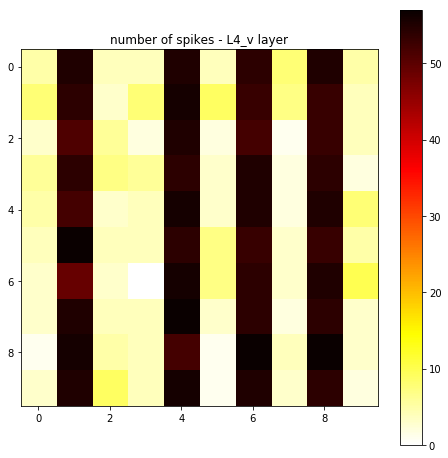

In [17]:
plot_spike_counts('L4_v', (length//(w_s*2), length//l_s), fig_num)
fig_num += 1

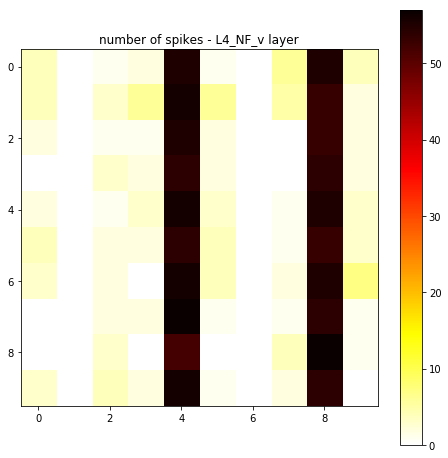

In [18]:
plot_spike_counts('L4_NF_v', (length//(w_s*2), length//l_s), fig_num)
fig_num += 1

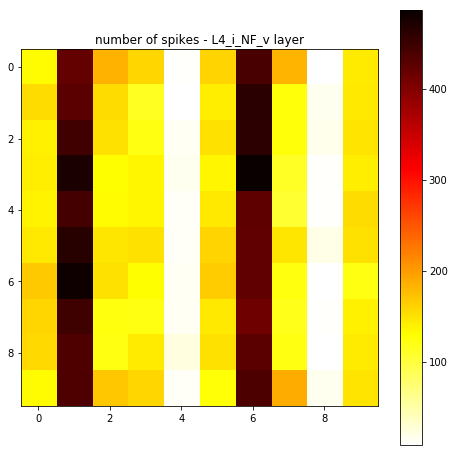

In [19]:
plot_spike_counts('L4_i_NF_v', (length//(w_s*2), length//l_s), fig_num)
fig_num += 1

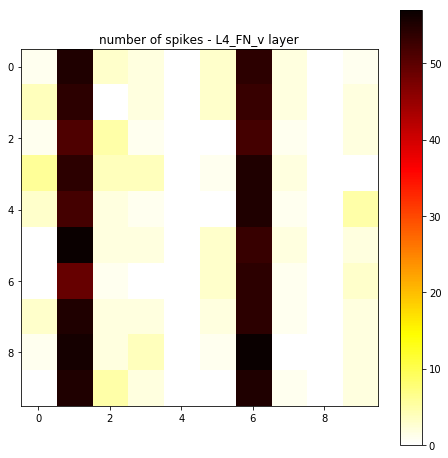

In [20]:
plot_spike_counts('L4_FN_v', (length//(w_s*2), length//l_s), fig_num)
fig_num += 1

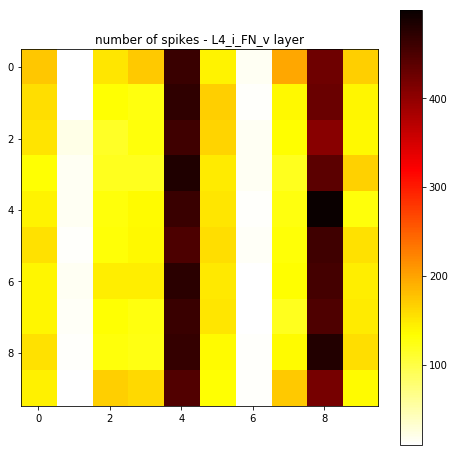

In [21]:
plot_spike_counts('L4_i_FN_v', (length//(w_s*2), length//l_s), fig_num)
fig_num += 1

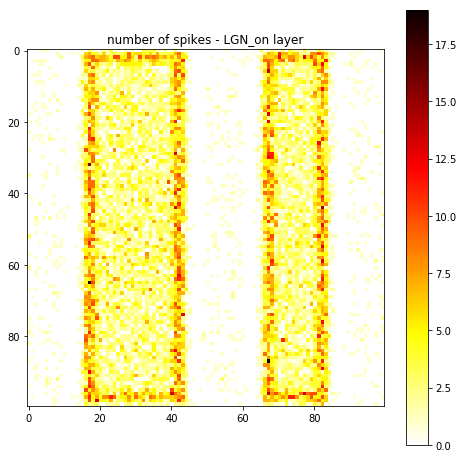

In [22]:
plot_spike_counts('LGN_on', (length,length), fig_num)
fig_num += 1

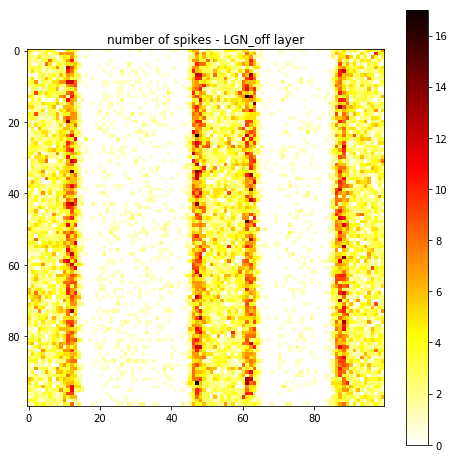

In [23]:
plot_spike_counts('LGN_off', (length,length), fig_num)
fig_num += 1

In [24]:
# plot(state_monitors['L4_v'].t/ms, state_monitors['L4_v'].v[0], label='L4_v')
# plot(state_monitors['L4_i_v'].t/ms, state_monitors['L4_i_v'].v[0], label='L4_i_v')
# xlabel('Time (ms)')
# ylabel('v')
# legend();